# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

![Alt text](https://imgur.com/orZWHly.png)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

[Text(0.5, 0, 'Values')]

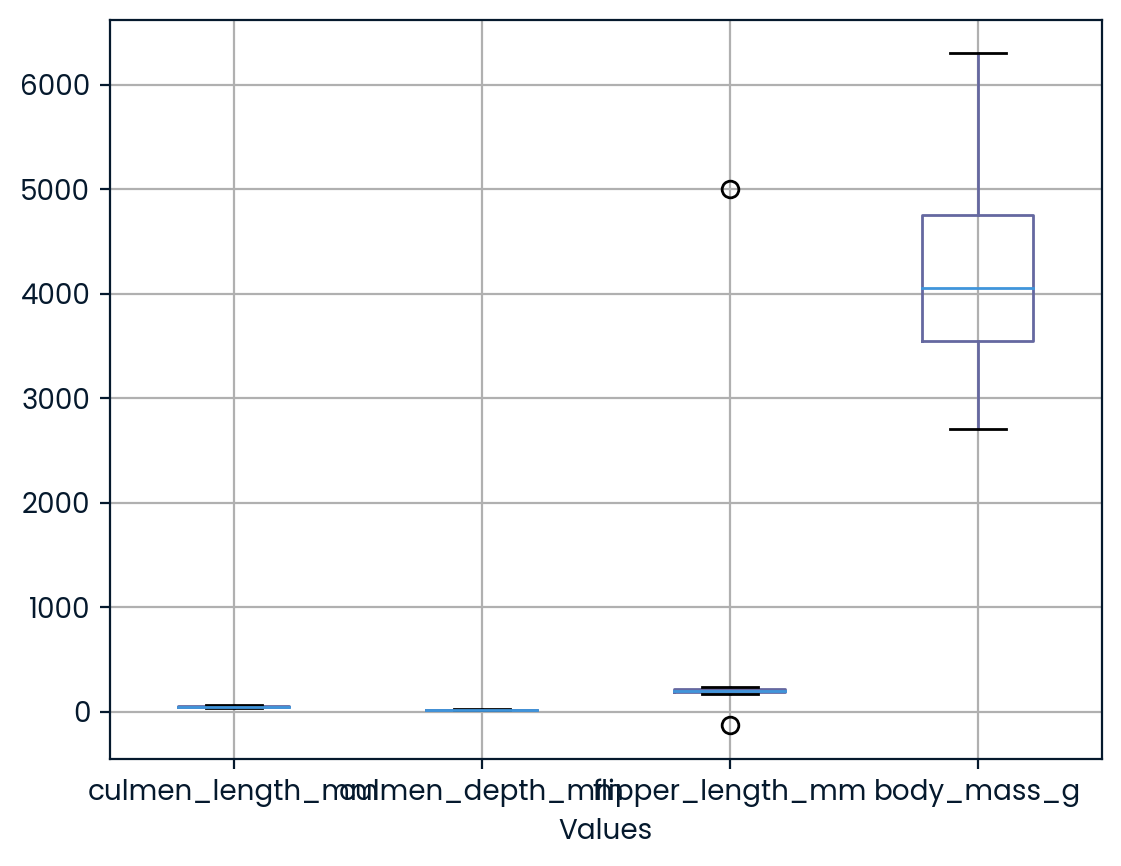

In [66]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading and examining the dataset
penguins_df = pd.read_csv("data/penguins.csv")

penguins_df.boxplot()
# penguins_df.var()
plt.gca().set(xlabel="Values") 

### Define a function to remove outliers from the identified skewed column: flipper_length_mm

Plotting histogram of feature flipper_length_mm to ensure it is no longer skewed
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


<AxesSubplot: >

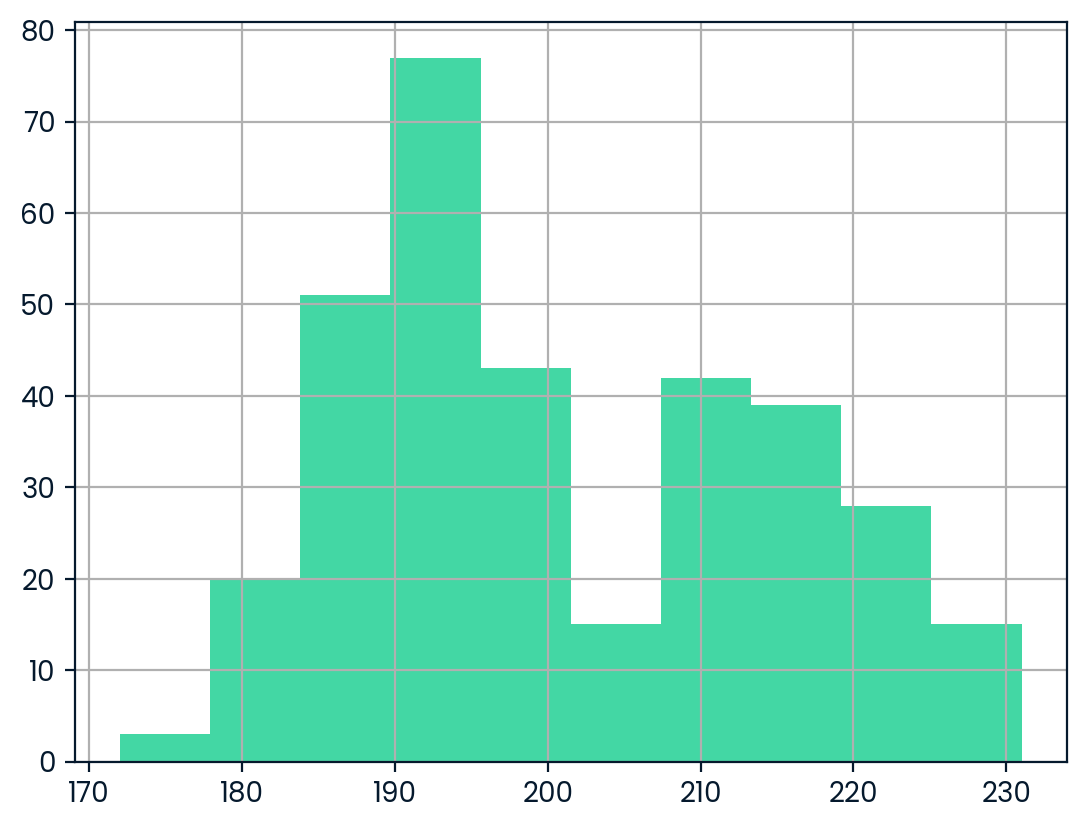

In [67]:

def find_outliers(df, column:str):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    #two ways to apply the mask, using subsetting or using the query method 
    mask = (df[column] < upper_bound ) & (df[column] > lower_bound)
  
    #in the other method we will return the dataframe 
    # clean_df = df.query(f"{column} < @lower_bound | {column} > @ upper_bound")
    #you can return the clean_df if you want to use this method
    
    clean_df = df[mask]
    
    print(f"Plotting histogram of feature {column} to ensure it is no longer skewed")
    clean_df.dropna(inplace=True)
    clean_df[column].hist()
    return clean_df

penguins_clean = find_outliers(penguins_df, "flipper_length_mm")
print(penguins_clean.isna().sum())
# penguins_clean.shape
penguins_clean["flipper_length_mm"].hist()

In [68]:
df = pd.get_dummies(penguins_clean, prefix="CAT")
df = df.drop(columns='CAT_.')
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,CAT_FEMALE,CAT_MALE
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
4,36.7,19.3,193.0,3450.0,1,0
5,39.3,20.6,190.0,3650.0,0,1


In [69]:
#scale the data
scaler = StandardScaler()

scaled = scaler.fit_transform(df)

penguins_preprocessed = pd.DataFrame(scaled, columns=df.columns)

#to check variance
penguins_preprocessed.var()

culmen_length_mm     1.003012
culmen_depth_mm      1.003012
flipper_length_mm    1.003012
body_mass_g          1.003012
CAT_FEMALE           1.003012
CAT_MALE             1.003012
dtype: float64

### Applying pca and removing features with explained_variance_ratio less than 10%

In [70]:
#perform PCA decomposition
pca = PCA()
pca.fit(penguins_preprocessed)
mask = pca.explained_variance_ratio_ > 0.1

#find number of components
n_components = mask.sum()
print(n_components)

print("Important features are")
list(penguins_preprocessed.loc[:, mask].columns)

2
Important features are


['culmen_length_mm', 'culmen_depth_mm']

In [71]:
#calling pca again with n_components 
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)
penguins_PCA.shape

(333, 2)

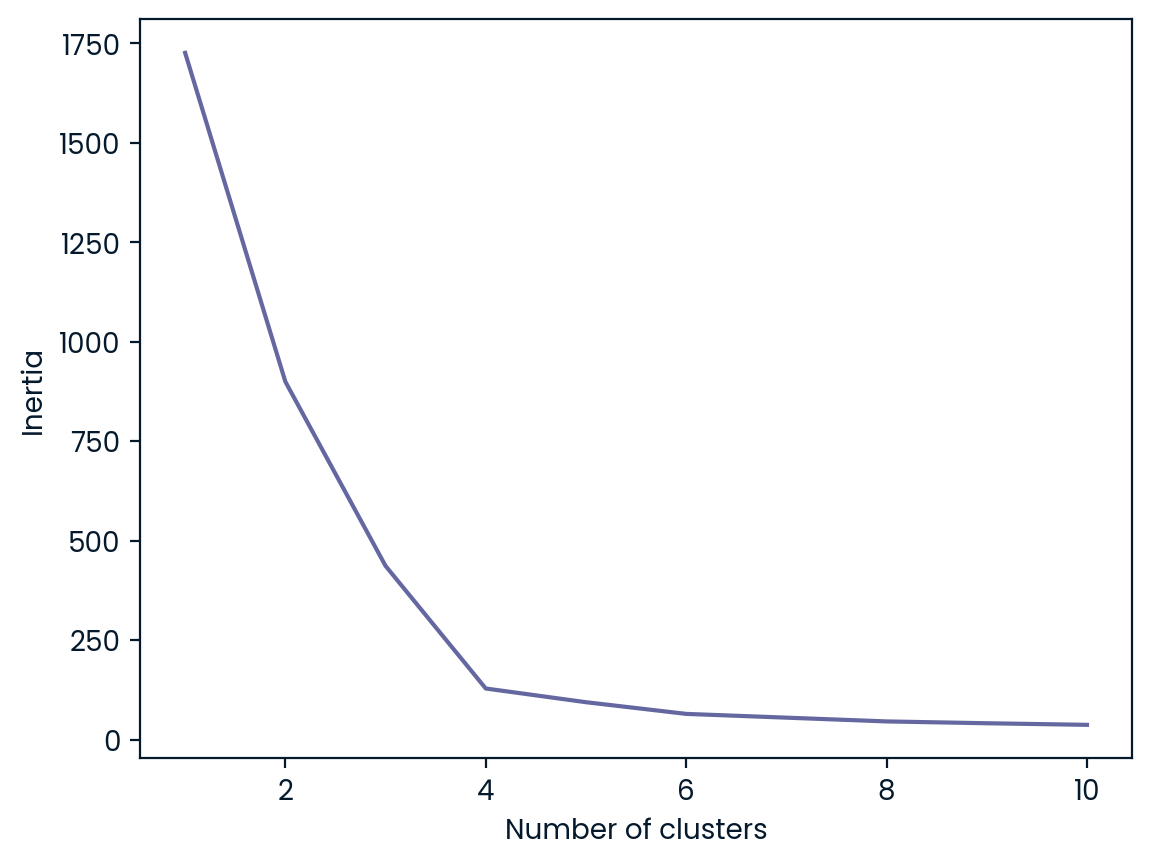

In [72]:
#finding optimal n_cluster for kmeans 
inertia_list = []

k_values = range(1,11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(penguins_PCA)
    inertia_list.append(kmeans.inertia_)

plt.plot(k_values, inertia_list)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()


### Fitting the KMeans model with the best cluster

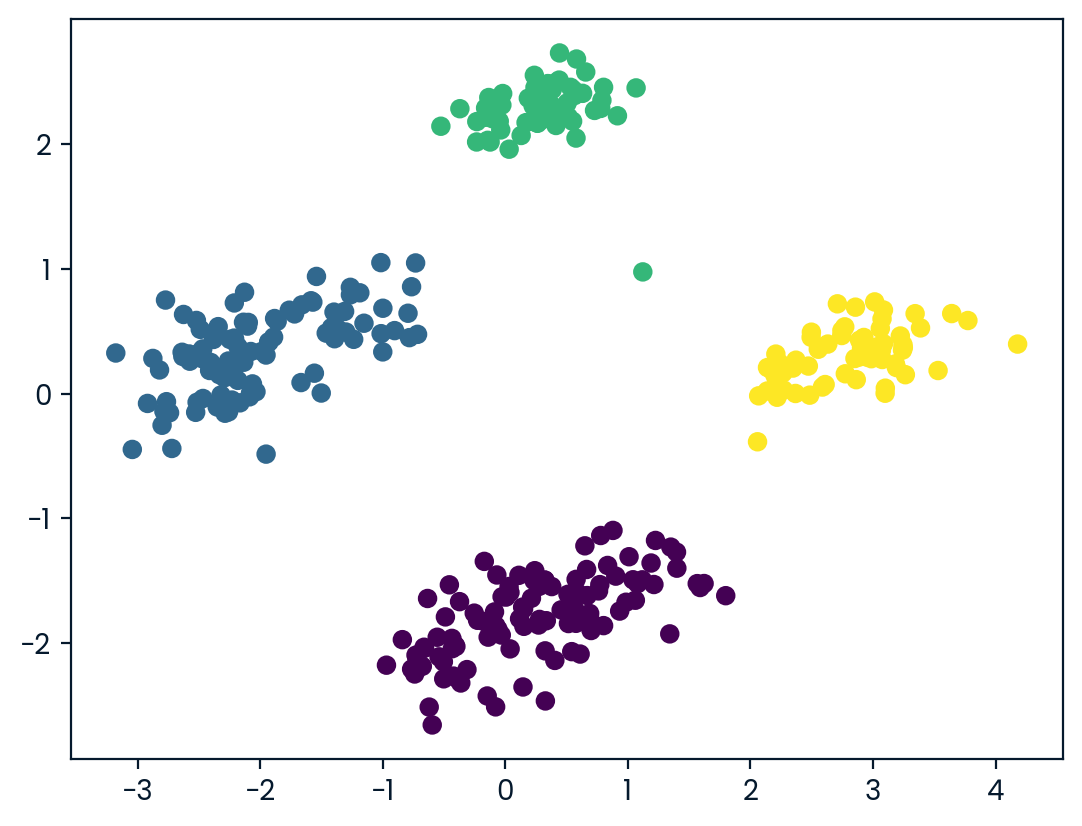

In [73]:
#from the elbow plot it appears cluster of 5 might be good
#running kmeans with the 5 clusters 
n_clusters=4
best_model = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)

plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=best_model.labels_)
plt.show()

### Creating Final Dataset

In [77]:
penguins_clean['label'] = best_model.labels_
sorted(penguins_clean['label'].unique())

[0, 1, 2, 3]

### Finding numeric columns and converting to list for grouping the new dataset

In [78]:
mask = penguins_clean.dtypes == 'float64'
numeric = penguins_clean.columns[mask]
numeric_columns = list(numeric)
numeric_columns

['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

### Creating a new dataframe from grouping penguins_clean by label

In [81]:
final_dataset = penguins_clean.groupby('label')[numeric_columns].mean()
final_dataset.shape
final_dataset

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0,43.878302,19.111321,194.764151,4006.603774
1,40.217757,17.611215,189.046729,3419.158879
2,45.545763,14.262712,212.779661,4683.050847
3,49.473770,15.718033,221.540984,5484.836066
